# Business Case 5

## Mind Over Data - Retail Challenge 

**Group members:**
- Lorenzo Pigozzi	--- m20200745
- Nguyen Huy Phuc	--- m20200566
- Ema Mandura	  --- m20200647
- Xavier Goncalves  --- m20201090

#### **Expected outcomes**

- **How can I understand each Point-of-Sale characteristics ?**\
  Quarterly analysis of
     - Top products sold
     - Market Share (Family, Category), preferences
     - Product co-ocorrences
- **Point-of-Sales Clustering**
 - Value
 - Product preference
- **Forecasting**
 - Units Product forecast (6 weeks ahead)
 - Units Product forecast by Poit-of-Sale (6 weeks ahead)

<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[EDA and Cleaning](#2)       
3.	[Clustering](#3)\
 3.1. [PoS Clusters by Value](#3.1.)\
 3.2. [PoS Clusters by Product Preference](#3.2.)\
 3.3. [Family-Product Clusters](#3.3.)
4.	[Forecasting](#4)

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from os import path
import math
import datetime
import time

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram

In [2]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Price':'float32',
    'Quantity':'float32'
}

path = r"C:\Users\lorep\Documents\Master\Business Cases\BC5\dataset\df_final.csv"

In [3]:
df = pd.read_csv(path, dtype = dtype_dict)

# 2. EDA and Cleaning <a class="anchor" id="2"></a>

In [4]:
df = df.iloc[:, 1:]

In [5]:
df.head()

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0               16                 11             306            649   
1               16                 11             306            649   
2               16                 11             306            649   
3               16                 11             306            649   
4               16                 11             306            649   

  ProductPackSKU_ID Point-of-Sale_ID        Date   Price  Quantity  
0              1970                1  2017-03-04  1540.0       2.0  
1              1970                1  2016-05-02  3080.0       4.0  
2              1970                1  2016-10-24  1540.0       2.0  
3              1970                1  2017-10-13  1620.0       2.0  
4              1970                1  2017-10-14  1620.0       2.0

In [6]:
df.shape

(91171152, 9)

In [7]:
df.isna().sum()

ProductFamily_ID      0
ProductCategory_ID    0
ProductBrand_ID       0
ProductName_ID        0
ProductPackSKU_ID     0
Point-of-Sale_ID      0
Date                  0
Price                 0
Quantity              0
dtype: int64

In [8]:
df[df['Price'] < 0]

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
55701073               21                117            1472           1229   

         ProductPackSKU_ID Point-of-Sale_ID        Date  Price  Quantity  
55701073              3668              252  2017-04-19  -10.0       2.0

In [9]:
df[df['Price'] == 0]

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
1441884                21                159             545           1089   
5572692                18                175            1142           2102   
5572693                18                175            1142           2102   
5572694                18                175            1142           2102   
5572695                18                175            1142           2102   
...                   ...                ...             ...            ...   
90868045               19                174             940           1784   
90868046               19                174             940           1784   
90868047               19                174             940           1784   
90868048               19                174             940           1784   
91112535               21                109             363            744   

         ProductPackSKU_ID Point-of-Sale_ID        Date  Price  Quantity  
1441884               3276                6  2016-03-14    0.0       3.0  
5572692               6353               23  2017-11-21    0.0       1.0  
5572693               6353               23  2018-06-25    0.0       1.0  
5572694               6353               23  2016-03-21    0.0       1.0  
5572695               6353               23  2016-11-01    0.0       2.0  
...                    ...              ...         ...    ...       ...  
90868045              5384              409  2019-05-17    0.0       1.0  
90868046              5384              409  2017-02-27    0.0       1.0  
90868047              5384              409  2018-05-02    0.0       1.0  
90868048              5384              409  2018-02-07    0.0       1.0  
91112535              2260              410  2016-04-01    0.0       1.0  

[669 rows x 9 columns]

Be careful!\
There are few rows with price equal to zero, and one even negative.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91171152 entries, 0 to 91171151
Data columns (total 9 columns):
 #   Column              Dtype   
---  ------              -----   
 0   ProductFamily_ID    category
 1   ProductCategory_ID  category
 2   ProductBrand_ID     category
 3   ProductName_ID      category
 4   ProductPackSKU_ID   category
 5   Point-of-Sale_ID    category
 6   Date                object  
 7   Price               float32 
 8   Quantity            float32 
dtypes: category(6), float32(2), object(1)
memory usage: 2.3+ GB


In [11]:
# changing the datatype
df["Date"] = pd.to_datetime(df["Date"])

In [20]:
# distribution of days over the year
date_frequency = df['Date'].dt.date.value_counts().reset_index()
date_frequency.columns = ['date', 'total_frequency']
date_frequency = date_frequency.sort_values(by='date')
##plotting##
data_for_plot = dict(type='scatter',
                x=date_frequency['date'],
                y=date_frequency['total_frequency'])
# setting the layout
plot_1_layout = dict(title=dict(text='Frequency purchases over the year'),
                      xaxis=dict(title='Month'),
                      yaxis=dict(title='Total Frequency')
                      )
# displaying the graph
plot_1 = go.Figure(data=data_for_plot, layout=plot_1_layout)
# plot_1.show(renderer='png')
plot_1.show()

### Outliers

In [21]:
len(df['ProductBrand_ID'].unique())

1523

In [22]:
len(df['ProductName_ID'].unique())

2820

In [23]:
len(df['Point-of-Sale_ID'].unique())

410

Text(0.5, 1.0, 'Histogram')

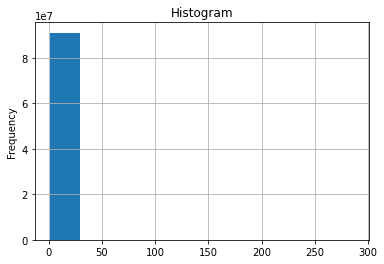

In [24]:
# distribution of the quantity
df['Quantity'].hist()
plt.ylabel('Frequency')
# plt.xlabel('Days of Failure (%)')
plt.title('Histogram')

Text(0.5, 1.0, 'Histogram')

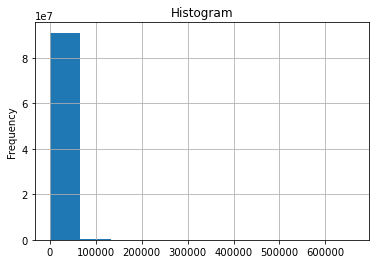

In [26]:
# distribution of the quantity
df['Price'].hist()
plt.ylabel('Frequency')
# plt.xlabel('Days of Failure (%)')
plt.title('Histogram')

In [27]:
# dropping some outlier considering the quantity
print('Percentage of outliers for Quantity : ',
    len(df[df['Quantity'] > 50]) / df.shape[0])

Percentage of outliers for Quantity :  2.551245595755991e-05


In [29]:
# dropping some outlier considering the quantity
print('Percentage of outliers for Monetary Value : ',
    len(df[df['Price'] > 150000]) / df.shape[0])

Percentage of outliers for Monetary Value :  2.498597363341422e-05


**Notes**

\
Brands: 1523\
Product names: 2820\
Point of sales: 410

\
For the data we're analyzing, the quantity and monetary value are aggregated by day, it's not purely a transactional dataset. Considering that, we can drop the outliers for the Quantity and Monetary value, also because the percentages are really small and the numbers are really far away from the distributions.


In [12]:
# dropping the outliers
df = df[df['Price'] < 150000]
df = df[df['Quantity'] < 50]

In [13]:
def top_frequencies(col):
    # checking the top countries
    top_countries = pd.DataFrame(df[col].value_counts().head(10)).reset_index()
    top_countries.columns = [col, 'value']

    fig = px.bar(top_countries, y = col, x = 'value', orientation='h', 
                 color=col, color_discrete_sequence=px.colors.qualitative.Antique,
                title='Top '+ col)
    fig.show()

In [14]:
top_frequencies('ProductBrand_ID')

In [15]:
top_frequencies('ProductName_ID')

In [16]:
top_frequencies('Point-of-Sale_ID')

# 3. Clustering <a class="anchor" id="3"></a>

\
**Point-of-Sales Clustering**
 - Value
 - Product preference

In [ ]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
   
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def R2(df,df_concat, labels):
    sst = get_ss(df)  # get total sum of squares
    ssw_labels = df_concat.groupby(by=labels).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2_ = ssb / sst
    return print("Cluster solution with R^2 of %0.4f" % r2_) 

def meanplot_df(df, labels):
    df_concat = pd.concat((df, pd.Series(labels, name='labels',index = df.index)), axis=1)
    plot_data = df_concat.groupby('labels').mean()
    sns.set_style("whitegrid")
    # Plot PCA data
    fig, ax = plt.subplots(figsize = (24,12))
    ax = sns.lineplot(data = plot_data.T,dashes = False)
    plt.xticks(rotation=45)
    plt.show()  
    
# Function to plot boxplot for each features based on clusters
def boxplot_withLabels(df, labels):
    # Concatenate the dataframe with the labels
    df_concat = pd.concat((df, pd.Series(labels, name='labels', index = df.index)), axis=1)
    # Set up figure
    rows = math.ceil(df.shape[1]/4)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(rows,4, constrained_layout=False, figsize=(24,5*rows))
    fig.suptitle("Box plot for each features\n", fontsize=25)
    # Draw nested boxplots
    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(x='labels', y=col, data=df_concat, ax=ax )
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x',labelsize = 'large') 
        ax.set_title(col,fontsize = 15)  
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    
    
# PCA
class PCA_combined(object):
    def __init__(self, df):
        self.df = df
        self.n_components = df.shape[1]
        self.pca_model = PCA(n_components = df.shape[1])

    def Explained_variance(self):
        pca = PCA()
        pca_feat = pca.fit_transform(self.df)
        metrics = pd.DataFrame(
                                {"Eigenvalue": pca.explained_variance_,
                                "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
                                "Proportion": pca.explained_variance_ratio_,
                                "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
                                index=range(1, pca.n_components_ + 1))
        return metrics

    def PCA_test(self, n_components):
        self.pca_model = PCA(n_components = n_components)
        pca_feat = self.pca_model.fit_transform(self.df)
        self.pca_feat_names = [f"PC{i}" for i in range(self.pca_model.n_components_)]
        self.pca_df_ = pd.DataFrame(pca_feat, index=self.df.index, columns=self.pca_feat_names)  # remember index=df_pca.index
        #Concat to the original value
        self.concat_pca_df_ = pd.concat([self.df, self.pca_df_], axis=1)
        

    def corr_PCA(self):
        loadings = self.concat_pca_df_.corr().loc[self.df.columns, self.pca_feat_names]
        return loadings

def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

In [135]:
df.head()

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0               16                 11             306            649   
1               16                 11             306            649   
2               16                 11             306            649   
3               16                 11             306            649   
4               16                 11             306            649   

  ProductPackSKU_ID Point-of-Sale_ID       Date   Price  Quantity  
0              1970                1 2017-03-04  1540.0       2.0  
1              1970                1 2016-05-02  3080.0       4.0  
2              1970                1 2016-10-24  1540.0       2.0  
3              1970                1 2017-10-13  1620.0       2.0  
4              1970                1 2017-10-14  1620.0       2.0

## 3.1. PoS Clusters by value <a class="anchor" id="3.1."></a>

In [137]:
# selecting only the variables useful for the purpose
data = df[['Point-of-Sale_ID','Quantity', 'Price']]

In [138]:
data.head()

Point-of-Sale_ID  Quantity   Price
0                1       2.0  1540.0
1                1       4.0  3080.0
2                1       2.0  1540.0
3                1       2.0  1620.0
4                1       2.0  1620.0

In [139]:
data['Point-of-Sale_ID'].unique()

['1', '2', '3', '4', '5', ..., '406', '407', '408', '409', '410']
Length: 410
Categories (410, object): ['1', '2', '3', '4', ..., '407', '408', '409', '410']

In [140]:
# agg_sales_df = data.groupby('Point-of-Sale_ID').sum()[['Price']]
# agg_sales_df['Transaction_counts'] = data.groupby('Point-of-Sale_ID').count()['Quantity']
# agg_sales_df['Avg_quantity'] = data.groupby('Point-of-Sale_ID').mean()['Quantity']

In [148]:
# creation of the Average Monetary Value
data['Avg_MV'] = data['Price'] / data['Quantity']

<ipython-input-148-cefcf6f13c88>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [149]:
# grouping by the Point Of Sales
df_mean = data.groupby('Point-of-Sale_ID').mean()

In [150]:
df_mean.head()

Quantity        Price       Avg_MV
Point-of-Sale_ID                                    
1                 3.197260  5133.136719  1557.852905
2                 2.170184  3529.891357  1508.689819
3                 2.189074  3804.852051  1564.847534
4                 2.069221  3272.064941  1488.888428
5                 1.824098  2882.477783  1504.717285

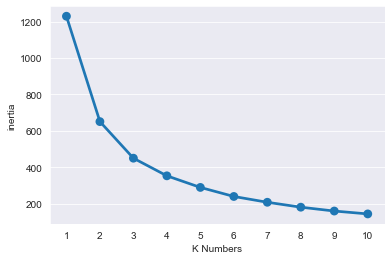

In [151]:
scaler = StandardScaler()
aggdf_scaled = scaler.fit_transform(df_mean)
# transform into a dataframe
aggdf_scaled = pd.DataFrame(aggdf_scaled, index = df_mean.index, columns = df_mean.columns)

inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(aggdf_scaled)
    inertia[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('inertia')
plt.show()

In [152]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300,random_state=2)
clus.fit(aggdf_scaled)
# Assign the clusters to datamart
df_mean['K_Cluster_Value'] = clus.labels_
df_mean.head()

Quantity        Price       Avg_MV  K_Cluster_Value
Point-of-Sale_ID                                                     
1                 3.197260  5133.136719  1557.852905                1
2                 2.170184  3529.891357  1508.689819                2
3                 2.189074  3804.852051  1564.847534                2
4                 2.069221  3272.064941  1488.888428                2
5                 1.824098  2882.477783  1504.717285                2

<AxesSubplot:xlabel='Price', ylabel='Avg_MV'>

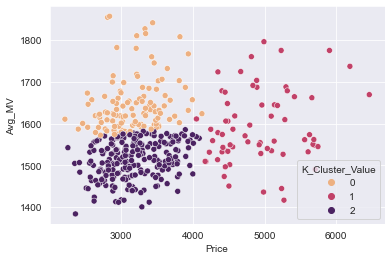

In [153]:
sns.set_style("darkgrid")
sns.scatterplot(x = "Price", y="Avg_MV", hue="K_Cluster_Value", data=df_mean, palette= 'flare')

<AxesSubplot:xlabel='K_Cluster_Value', ylabel='count'>

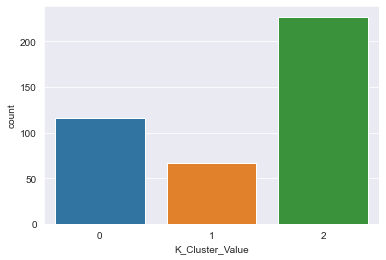

In [154]:
sns.countplot(x="K_Cluster_Value", data=df_mean)

In [155]:
R2(df_mean.iloc[:,:-1], df_mean, 'K_Cluster_Value')

Cluster solution with R^2 of 0.6988


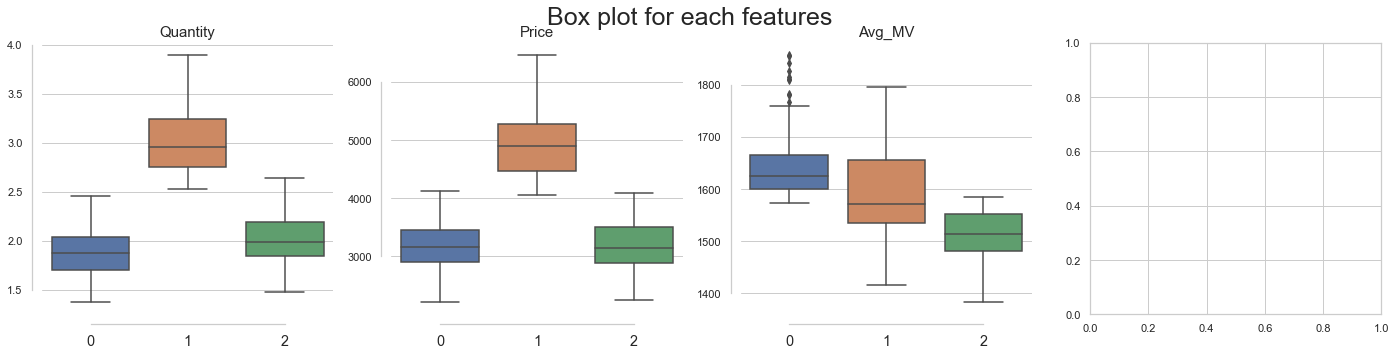

In [227]:
boxplot_withLabels(df_mean.iloc[:, :-1], df_mean['K_Cluster_Value'])

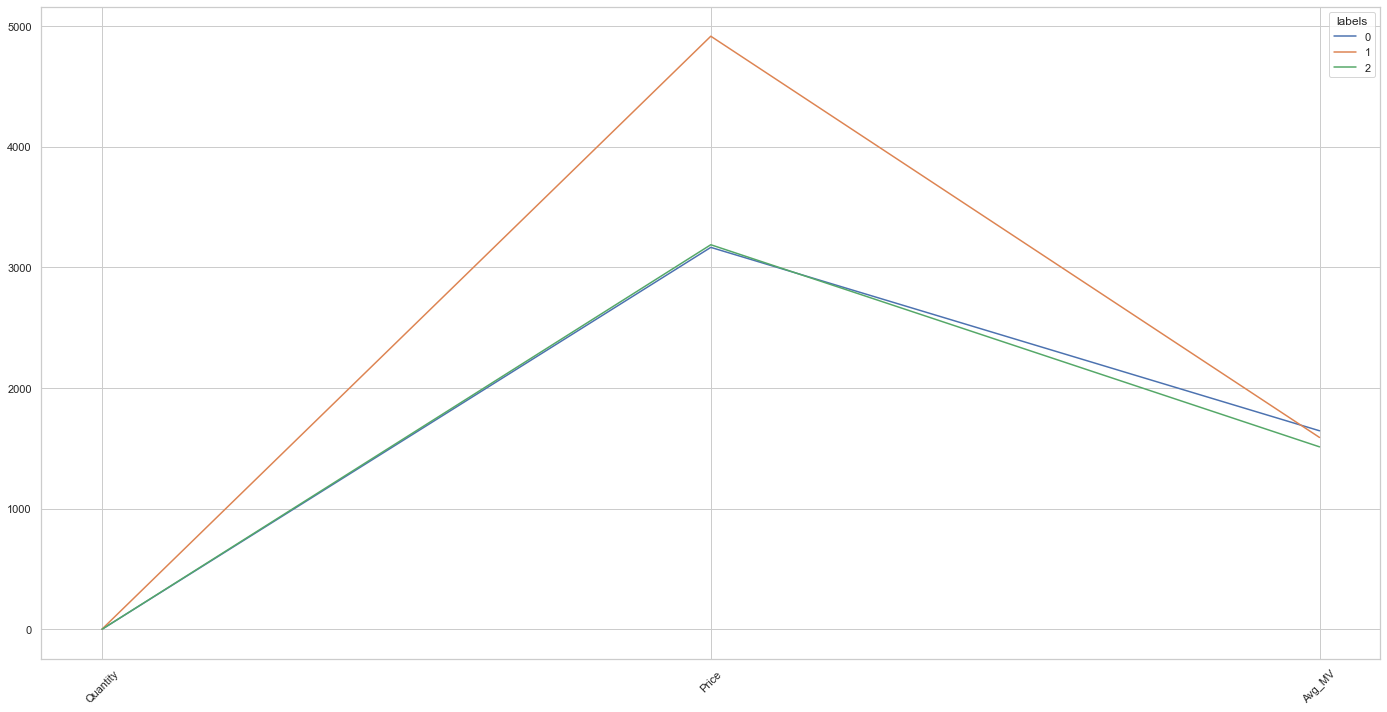

In [229]:
meanplot_df(df_mean.iloc[:,:-1], df_mean.iloc[:,-1])

### **Point of Sales Clusters by Value | Interpretation**
 
<font size=4 color='red'>**Cluster 0: "The Boutique"** </font>
 - **Characteristics**
     - Lowest Quantity of products purchased
     - Lowest Amount of Monetary Value
     - Highest Average of Monetary Value

<font size=4 color='orange'>**Cluster 1: "The standard Store"** </font>
 - **Characteristics**
     - Highest Quantity
     - Highest total amount of Monetary Value
     - Regular Average of Monetary Value
     
<font size=4 color='green'>**Cluster 2: "The Discount"** </font>
 - **Characteristics**
     - Regular Quantity of products purchased
     - Regular Amount of Monetary Valu
     - Lowest Average of Monetary Value

## 3.2. PoS Clusters by Product-family <a class="anchor" id="3.2."></a>

In [76]:
# agg_family = data.groupby(['Point-of-Sale_ID','ProductFamily_ID']).mean()
# agg_family.to_csv(r"C:\Users\lorep\Documents\Master\Business Cases\BC5\dataset\agg_family_2.csv")

# df2 = df[['ProductFamily_ID', 'Point-of-Sale_ID', 'Quantity']]
# agg_family = df2.groupby(['Point-of-Sale_ID','ProductFamily_ID']).count()
# agg_family.to_csv(r"C:\Users\lorep\Documents\Master\Business Cases\BC5\dataset\agg_family.csv")

In [311]:
agg_family = pd.read_csv(r"C:\Users\lorep\Documents\Master\Business Cases\BC5\dataset\agg_family.csv")

In [312]:
agg_family.head()

Point-of-Sale_ID  ProductFamily_ID  Quantity
0                 1                 1     32459
1                 1                10      2460
2                 1                11       400
3                 1                12     36862
4                 1                13      1316

In [313]:
test_df = agg_family.reset_index(drop =True)

In [324]:
pivot_df = pd.pivot_table(test_df, index='Point-of-Sale_ID', columns='ProductFamily_ID', 
                    aggfunc=lambda x: x if len(x)>0 else 0).fillna(0)

In [325]:
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

In [326]:
pivot_df.head()

Quantity                                                    \
ProductFamily_ID        1         2         3         4         5         6    
Point-of-Sale_ID                                                               
1                 0.170430  0.055578  0.014502  0.001244  0.007939  0.012418   
2                 0.186305  0.059973  0.013296  0.000489  0.007232  0.011279   
3                 0.189802  0.056752  0.013711  0.001008  0.006277  0.014679   
4                 0.170438  0.042863  0.009649  0.000582  0.004488  0.012526   
5                 0.161121  0.057175  0.013409  0.000751  0.007078  0.012736   

                                                          ...            \
ProductFamily_ID        7         8         9         10  ...        12   
Point-of-Sale_ID                                          ...             
1                 0.005455  0.019979  0.224637  0.012917  ...  0.193548   
2                 0.006276  0.020150  0.233292  0.008366  ...  0.211235   
3                 0.006666  0.018486  0.241554  0.007252  ...  0.199386   
4                 0.004153  0.013903  0.223651  0.010925  ...  0.224961   
5                 0.005511  0.016340  0.258256  0.009598  ...  0.213251   

                                                                              \
ProductFamily_ID        13        14        15        16        17        18   
Point-of-Sale_ID                                                               
1                 0.006910  0.030774  0.064751  0.016182  0.001029  0.042567   
2                 0.006187  0.030773  0.070312  0.018677  0.000245  0.034764   
3                 0.004745  0.023522  0.066385  0.016695  0.000473  0.033525   
4                 0.005010  0.018802  0.054040  0.011232  0.000933  0.027198   
5                 0.005731  0.025623  0.061720  0.016560  0.000777  0.035994   

                                                
ProductFamily_ID        19        20        21  
Point-of-Sale_ID                                
1                 0.001428  0.000572  0.115041  
2                 0.000795  0.000445  0.078188  
3                 0.000997  0.000273  0.095598  
4                 0.001307  0.001112  0.158829  
5                 0.001144  0.000691  0.093834  

[5 rows x 21 columns]

In [327]:
# dropping a level of the column multindex
pivot_df.columns = pivot_df.columns.droplevel()

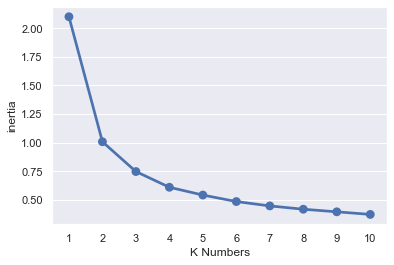

In [328]:
# scaler = StandardScaler()
# aggdf_scaled = scaler.fit_transform(pivot_df)

aggdf_scaled = pivot_df.copy()

# transform into a dataframe
aggdf_scaled = pd.DataFrame(aggdf_scaled, index = pivot_df.index, columns = pivot_df.columns)

inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(aggdf_scaled)
    inertia[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('inertia')
plt.show()

In [337]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300,random_state=2)
clus.fit(aggdf_scaled)
# Assign the clusters to datamart
pivot_df['K_Cluster_Product'] = clus.labels_
pivot_df.head()

ProductFamily_ID         1         2         3         4         5         6  \
Point-of-Sale_ID                                                               
1                 0.170430  0.055578  0.014502  0.001244  0.007939  0.012418   
2                 0.186305  0.059973  0.013296  0.000489  0.007232  0.011279   
3                 0.189802  0.056752  0.013711  0.001008  0.006277  0.014679   
4                 0.170438  0.042863  0.009649  0.000582  0.004488  0.012526   
5                 0.161121  0.057175  0.013409  0.000751  0.007078  0.012736   

ProductFamily_ID         7         8         9        10  ...        13  \
Point-of-Sale_ID                                          ...             
1                 0.005455  0.019979  0.224637  0.012917  ...  0.006910   
2                 0.006276  0.020150  0.233292  0.008366  ...  0.006187   
3                 0.006666  0.018486  0.241554  0.007252  ...  0.004745   
4                 0.004153  0.013903  0.223651  0.010925  ...  0.005010   
5                 0.005511  0.016340  0.258256  0.009598  ...  0.005731   

ProductFamily_ID        14        15        16        17        18        19  \
Point-of-Sale_ID                                                               
1                 0.030774  0.064751  0.016182  0.001029  0.042567  0.001428   
2                 0.030773  0.070312  0.018677  0.000245  0.034764  0.000795   
3                 0.023522  0.066385  0.016695  0.000473  0.033525  0.000997   
4                 0.018802  0.054040  0.011232  0.000933  0.027198  0.001307   
5                 0.025623  0.061720  0.016560  0.000777  0.035994  0.001144   

ProductFamily_ID        20        21  K_Cluster_Product  
Point-of-Sale_ID                                         
1                 0.000572  0.115041                  0  
2                 0.000445  0.078188                  0  
3                 0.000273  0.095598                  0  
4                 0.001112  0.158829                  1  
5                 0.000691  0.093834                  0  

[5 rows x 22 columns]

<AxesSubplot:xlabel='K_Cluster_Product', ylabel='count'>

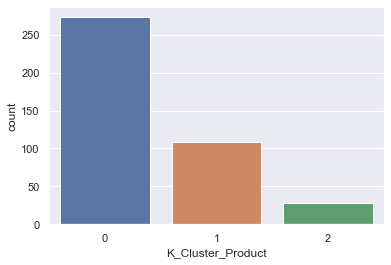

In [338]:
sns.countplot(x="K_Cluster_Product", data= pivot_df)

In [339]:
R2(pivot_df.iloc[:, :-1], pivot_df, "K_Cluster_Product")

Cluster solution with R^2 of 0.6441


In [342]:
# boxplot_withLabels(pivot_df.iloc[:, :-1], pivot_df['K_Cluster_Product'])

### PCA of the Product Family

In [344]:
pca = PCA() #n_components = 2
pca_feat = pca.fit_transform(pivot_df.iloc[:, :-1])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index = pivot_df.index, columns = pca_feat_names)
pca_df.head()

PC0       PC1       PC2       PC3       PC4       PC5  \
Point-of-Sale_ID                                                               
1                -0.018667  0.022873 -0.005262  0.009314  0.004683  0.002018   
2                -0.060103  0.014392 -0.000034 -0.003583  0.012239  0.000076   
3                -0.045148  0.025058 -0.014804 -0.009448  0.009378 -0.003183   
4                 0.018081 -0.014480 -0.029410 -0.006841  0.004160 -0.001176   
5                -0.051960  0.009285 -0.032783  0.016331  0.007867  0.000184   

                       PC6       PC7       PC8       PC9  ...      PC11  \
Point-of-Sale_ID                                          ...             
1                -0.002311 -0.002823 -0.001557  0.003157  ... -0.003209   
2                 0.004853  0.000922 -0.001704 -0.000785  ...  0.000006   
3                 0.002348  0.000273 -0.002872  0.001826  ...  0.000639   
4                 0.000420  0.001885 -0.000031 -0.001070  ... -0.000106   
5                 0.001716 -0.005289  0.000408  0.000382  ...  0.000102   

                      PC12      PC13      PC14      PC15      PC16      PC17  \
Point-of-Sale_ID                                                               
1                -0.001670 -0.001021 -0.000823 -0.000701  0.000523  0.000338   
2                -0.000262  0.000308 -0.000624 -0.000273  0.000841 -0.000295   
3                 0.001057  0.000074 -0.000899  0.000061  0.000102 -0.000956   
4                 0.000718 -0.001261 -0.000519 -0.000868 -0.000055 -0.000010   
5                 0.000687 -0.000257 -0.000747 -0.000332  0.000321 -0.000261   

                      PC18      PC19          PC20  
Point-of-Sale_ID                                    
1                -0.000235  0.000027 -2.371982e-17  
2                -0.001001 -0.000052  5.001146e-17  
3                -0.000442 -0.000029 -2.128981e-17  
4                -0.000381 -0.000022 -3.494622e-18  
5                -0.000343 -0.000049 -3.543246e-18  

[5 rows x 21 columns]

In [345]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue    Difference    Proportion  Cumulative
1   4.103440e-03  0.000000e+00  7.989699e-01    0.798970
2   4.444566e-04 -3.658984e-03  8.653896e-02    0.885509
3   2.706594e-04 -1.737972e-04  5.269937e-02    0.938208
4   1.870479e-04 -8.361153e-05  3.641960e-02    0.974628
5   4.338114e-05 -1.436668e-04  8.446626e-03    0.983074
6   3.257161e-05 -1.080953e-05  6.341931e-03    0.989416
7   1.911965e-05 -1.345196e-05  3.722736e-03    0.993139
8   1.164545e-05 -7.474199e-06  2.267455e-03    0.995407
9   6.955983e-06 -4.689468e-06  1.354381e-03    0.996761
10  5.452603e-06 -1.503380e-06  1.061662e-03    0.997823
11  3.662311e-06 -1.790292e-06  7.130788e-04    0.998536
12  2.026717e-06 -1.635595e-06  3.946166e-04    0.998930
13  1.601345e-06 -4.253717e-07  3.117936e-04    0.999242
14  1.305836e-06 -2.955092e-07  2.542558e-04    0.999496
15  1.093289e-06 -2.125470e-07  2.128713e-04    0.999709
16  4.349965e-07 -6.582921e-07  8.469701e-05    0.999794
17  4.014997e-07 -3.349683e-08  7.817493e-05    0.999872
18  2.998516e-07 -1.016481e-07  5.838330e-05    0.999930
19  2.229382e-07 -7.691341e-08  4.340770e-05    0.999974
20  1.341488e-07 -8.878940e-08  2.611975e-05    1.000000
21  8.204201e-35 -1.341488e-07  1.597418e-32    1.000000

In [347]:
# considering 5 components, that already explain the 98 % of the variability
pca = PCA(n_components = 5) 
pca_feat = pca.fit_transform(pivot_df.iloc[:, :-1])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index = pivot_df.index, columns = pca_feat_names)
pca_df.head()

PC0       PC1       PC2       PC3       PC4
Point-of-Sale_ID                                                  
1                -0.018667  0.022873 -0.005262  0.009314  0.004683
2                -0.060103  0.014392 -0.000034 -0.003583  0.012239
3                -0.045148  0.025058 -0.014804 -0.009448  0.009378
4                 0.018081 -0.014480 -0.029410 -0.006841  0.004160
5                -0.051960  0.009285 -0.032783  0.016331  0.007867

In [350]:
clus = KMeans(n_clusters = 3, init= 'k-means++', max_iter= 300, random_state=2)
clus.fit(pca_df)
# Assign the clusters to datamart
pca_df['K_Cluster_Product'] = clus.labels_
pca_df.head()

PC0       PC1       PC2       PC3       PC4  \
Point-of-Sale_ID                                                     
1                -0.018667  0.022873 -0.005262  0.009314  0.004683   
2                -0.060103  0.014392 -0.000034 -0.003583  0.012239   
3                -0.045148  0.025058 -0.014804 -0.009448  0.009378   
4                 0.018081 -0.014480 -0.029410 -0.006841  0.004160   
5                -0.051960  0.009285 -0.032783  0.016331  0.007867   

                  K_Cluster_Product  
Point-of-Sale_ID                     
1                                 0  
2                                 0  
3                                 0  
4                                 1  
5                                 0

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

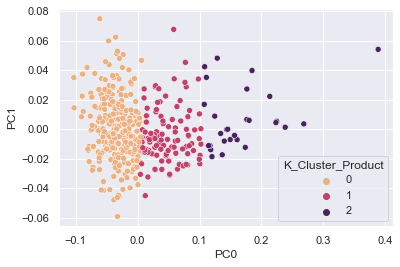

In [351]:
sns.set_style("darkgrid")
sns.scatterplot(x = "PC0", y = "PC1", hue="K_Cluster_Product", data = pca_df, palette= 'flare')

<AxesSubplot:xlabel='K_Cluster_Product', ylabel='count'>

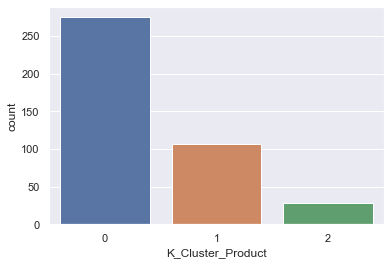

In [352]:
sns.countplot(x="K_Cluster_Product", data= pca_df)

In [193]:
# R2 score of the cluster solution
R2(pca_df.iloc[:,:-1], pca_df, 'K_Cluster_Product')

Cluster solution with R^2 of 0.6551


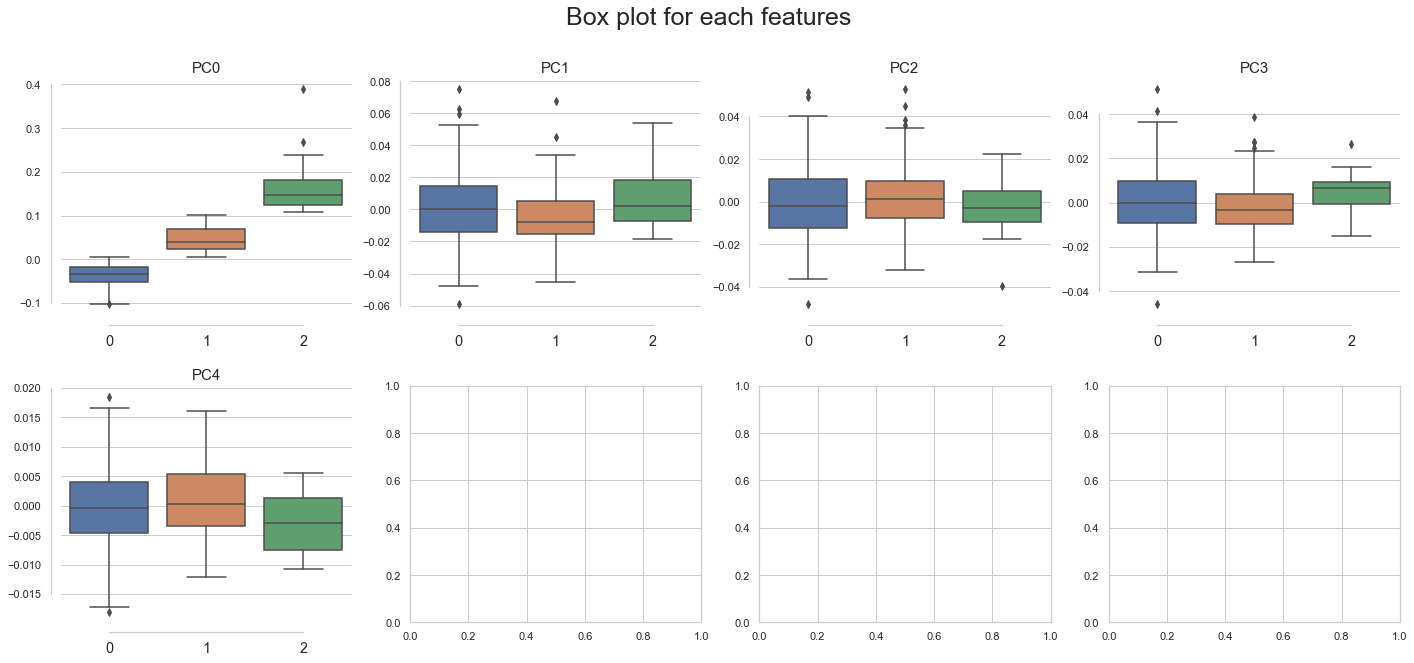

In [354]:
# interpretation of the clusters
boxplot_withLabels(pca_df.iloc[:, :-1], pca_df['K_Cluster_Product'])

In [357]:
# interpretation of the PCA
pca_combined = PCA_combined(pivot_df.iloc[:, :-1])
pca_combined.PCA_test(n_components = 10)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

### **Point of Sales Clusters by Product Preference | Interpretation**
 
<font size=4 color='red'>**Cluster 0** </font>
 - **High percentage of Product-Families**
     - Family 9
     - Family 2
     - Family 18
     - Family 3 
 - **Low percentage of Product-Families**
     - Family 21
     - Family 11
     - Family 10
     - Family 20 
     
<font size=4 color='orange'>**Cluster 1** </font>
 - **High percentage of Product-Families**
     - Family 15
 - **Low percentage of Product-Families**
     - Family 12
     
<font size=4 color='green'>**Cluster 2** </font>
 - **High percentage of Product-Families**
     - Family 21
     - Family 11
     - Family 10
     - Family 20
 - **Low percentage of Product-Families**
     - Family 9
     - Family 2
     - Family 18
     - Family 3  
     - Family 1

### Merging the clusters

In [361]:
df_merged = pca_df.merge(df_mean, on = pca_df.index).set_index(pca_df.index).drop(columns="key_0")
df_merged.head()

PC0       PC1       PC2       PC3       PC4  \
Point-of-Sale_ID                                                     
1                -0.018667  0.022873 -0.005262  0.009314  0.004683   
2                -0.060103  0.014392 -0.000034 -0.003583  0.012239   
3                -0.045148  0.025058 -0.014804 -0.009448  0.009378   
4                 0.018081 -0.014480 -0.029410 -0.006841  0.004160   
5                -0.051960  0.009285 -0.032783  0.016331  0.007867   

                  K_Cluster_Product  Quantity        Price       Avg_MV  \
Point-of-Sale_ID                                                          
1                                 0  3.197260  5133.136719  1557.852905   
2                                 0  2.170184  3529.891357  1508.689819   
3                                 0  2.189074  3804.852051  1564.847534   
4                                 1  2.069221  3272.064941  1488.888428   
5                                 0  1.824098  2882.477783  1504.717285   

                  K_Cluster_Value  
Point-of-Sale_ID                   
1                               1  
2                               2  
3                               2  
4                               2  
5                               2

In [362]:
df_centroids = df_merged.groupby(['K_Cluster_Product','K_Cluster_Value']).mean()
df_centroids.head()

PC0       PC1       PC2       PC3  \
K_Cluster_Product K_Cluster_Value                                           
0                 0               -0.041491  0.012357  0.007611  0.008969   
                  1               -0.031276  0.000225 -0.001155  0.006295   
                  2               -0.033966 -0.002100 -0.002682 -0.002981   
1                 0                0.058986 -0.003289  0.002497  0.000007   
                  1                0.048072 -0.002386  0.002630 -0.002772   

                                        PC4  Quantity        Price  \
K_Cluster_Product K_Cluster_Value                                    
0                 0               -0.003195  1.831341  3078.334229   
                  1               -0.001657  3.066096  4944.518066   
                  2                0.000995  2.019029  3188.258545   
1                 0                0.000042  1.932909  3225.718262   
                  1               -0.000339  3.024394  4902.213867   

                                        Avg_MV  
K_Cluster_Product K_Cluster_Value               
0                 0                1616.128418  
                  1                1551.983032  
                  2                1509.805542  
1                 0                1638.249512  
                  1                1591.390015

In [363]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)
# Map the indexes
cluster_mapper = {}
for i, clust in zip(df_centroids.index, hclust_labels):
    cluster_mapper[clust] = i
cluster_mapper 

{4: (0, 0),
 6: (0, 1),
 7: (0, 2),
 5: (1, 0),
 2: (1, 1),
 3: (1, 2),
 1: (2, 0),
 0: (2, 1)}

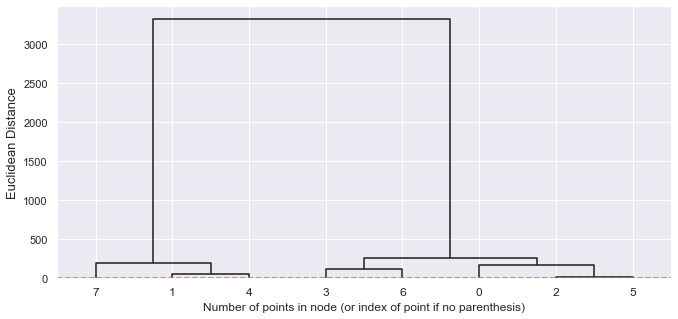

In [364]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4.5
dendrogram(linkage_matrix, truncate_mode='level',  p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
# plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [217]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=2
)

hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_merged.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['K_Cluster_Product'], row['K_Cluster_Value'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()

PC0       PC1       PC2       PC3       PC4  \
merged_labels                                                     
0             -0.004444  0.000033 -0.000121 -0.000516  0.000285   
1              0.022753 -0.000168  0.000621  0.002643 -0.001461   

               K_Cluster_Product  Quantity        Price       Avg_MV  \
merged_labels                                                          
0                       0.346939  1.974586  3181.019043  1558.408813   
1                       0.656716  3.016012  4916.523438  1591.156738   

               K_Cluster_Value  
merged_labels                   
0                     1.323615  
1                     1.000000

<AxesSubplot:xlabel='merged_labels', ylabel='count'>

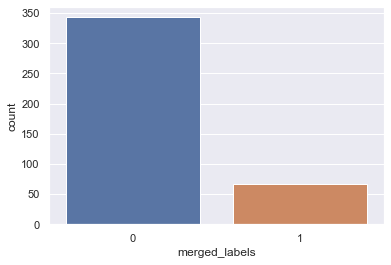

In [218]:
sns.countplot(x = df_['merged_labels'])

In [219]:
# Function to plot boxplot for each features based on clusters
def boxplot_withLabels(df, labels):
    # Concatenate the dataframe with the labels
    df_concat = pd.concat((df, pd.Series(labels, name='labels', index = df.index)), axis=1)
    # Set up figure
    rows = math.ceil(df.shape[1]/4)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(rows,4, constrained_layout=False, figsize=(24,5*rows))
    fig.suptitle("Box plot for each features\n", fontsize=25)
    # Draw nested boxplots
    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(x='labels', y=col, data=df_concat, ax=ax )
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x',labelsize = 'large') 
        ax.set_title(col,fontsize = 15)  
    fig.subplots_adjust(hspace=0.3)
    plt.show()

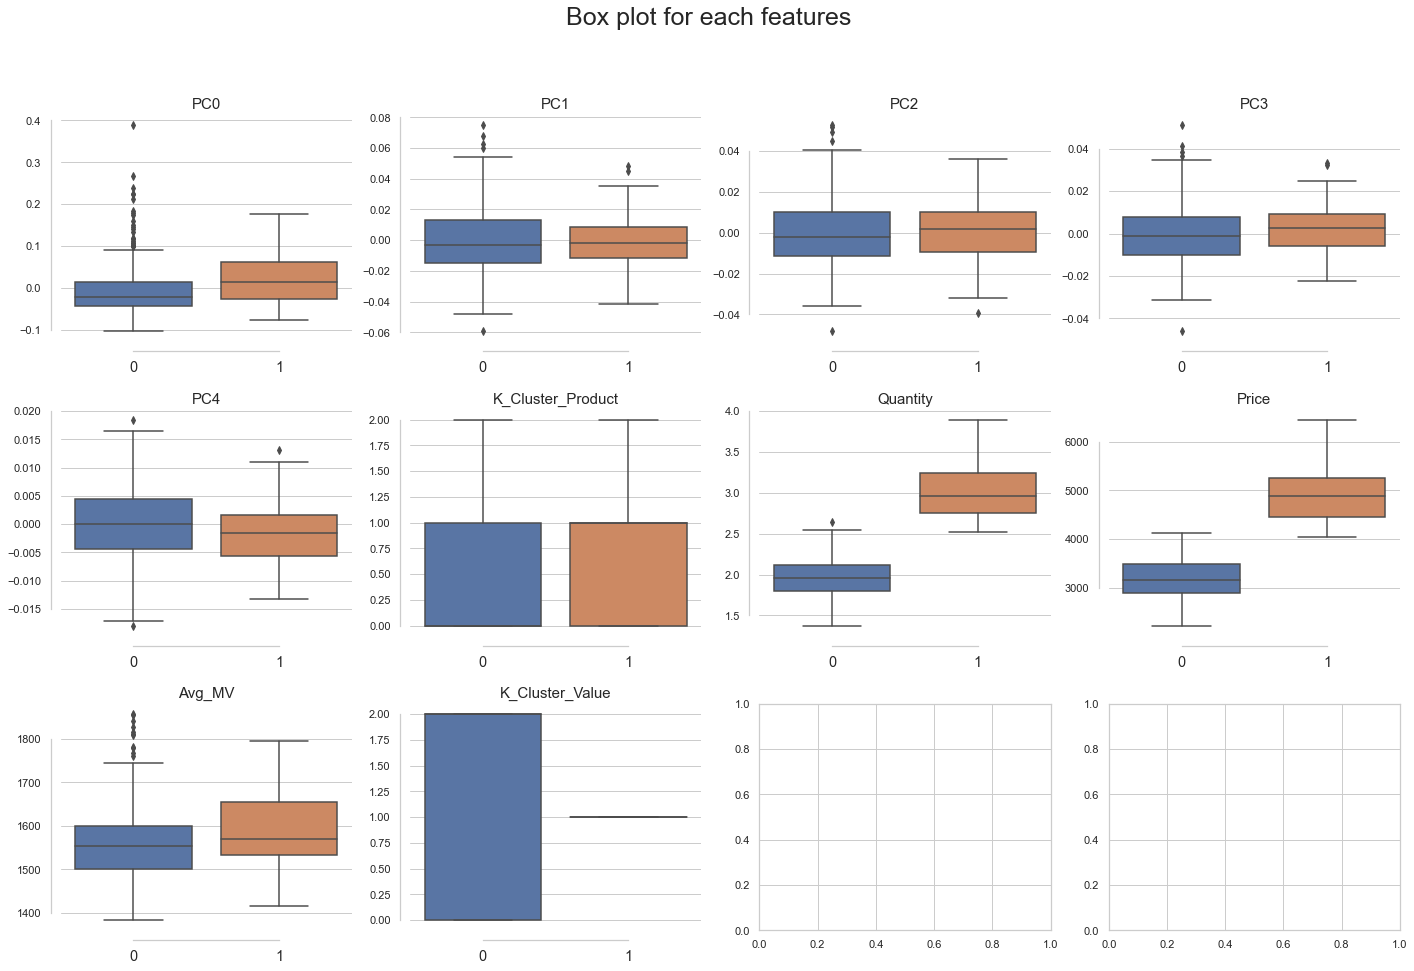

In [231]:
boxplot_withLabels(df_.iloc[:, :-1],df_['merged_labels'])

**Note for Cluster solution**\
Data shows that merging the 2 previous cluster's solutions is quite difficult and not optimal.\
For this reason we will continue with the original clusters created without merging them, and it will be possible to consider one perspective (clusters by value) or the other one (clusters by product preference) based on the business needs.

## 3.3. Family-Product Clusters <a class="anchor" id="3.3."></a>

In [41]:
def preprocessing(dataframe,product_id, period = "Month"):
    if period == "Month":
        data = dataframe[dataframe['ProductFamily_ID'] == product_id]
        data = data.groupby(['Year','Month']).sum()['Quantity'].reset_index()
        data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data['TimeSeries'] = data['Year'].astype('string') + data['Month']
        #drop non-relevant columns
        data.drop(['Year','Month'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.sort_index(inplace=True)
        print("monthly timeseries generated")
        return data
    elif period == "Week":
        data = dataframe[dataframe['ProductFamily_ID'] == product_id]
        data = data.groupby(['Year','Week']).sum()['Quantity'].reset_index()      
        data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data = data[data['Week'] != "53"]
        data['TimeSeries'] = data['Year'].astype('string') + data['Week']
        #drop non-relevant columns
        data.drop(['Year','Week'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.dropna(inplace=True)
        data.sort_index(inplace=True)
        print("weekly timeseries generated")
        return data
    else:
        print("Error, chosen period not available")   

def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    dataset_val = dataset.values
    for i in range(interval, len(dataset)):
        value = dataset_val[i] - dataset_val[i - interval]
        diff.append(value[0])
    return pd.DataFrame({'diff':diff},index = dataset[1:].index)

def scale_func(df,size_split):
    len_df = df.shape[0]
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:int(len_df*size_split),:])
    scaled_data = scaler.transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler
def reshape_input(X,Y):
    X, Y = np.array(X), np.array(Y)
    Y = Y.reshape(Y.shape[0], Y.shape[1])
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,Y
#create the training data set
def generate_input(df, window, out,size_split = 0.8):
    # df is the differencing dataframe
    #create the scaled training data set
    scaled_data, scaler = scale_func(df,size_split=size_split)
    #Split the data into x_train and y_train data sets
    len_df = scaled_data.shape[0]
    x_train,y_train = [],[]
    x_val,y_val = [],[]
    train_size = int(len_df*size_split)
    for i in range(window, train_size-out+1):
        x_train.append(scaled_data.iloc[i-window:i,:])
        y_train.append(scaled_data.iloc[i:(i+out),:])
    x_train,y_train = reshape_input(x_train,y_train)
    for i in range(train_size, len_df-out+1):
        x_val.append(scaled_data.iloc[i-window:i,:])
        y_val.append(scaled_data.iloc[i:(i+out),:])
    x_val,y_val = reshape_input(x_val,y_val)
    #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    return x_train, y_train, x_val,y_val, scaled_data,scaler

def model_base_build(input_shape,output_len):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=False,  input_shape = input_shape))
    #model.add(LSTM(10, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(output_len))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
# inverse data transform on forecasts
def inverse_transform(data, forecasts, scaler, x_val):
    inverted = list()
    out_put_len = forecasts.shape[1]
    for i in range(len(forecasts)): 
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(data) - len(x_val) + i - out_put_len
        last_ob = data.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def plot_series(data,figsize=(18,8)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)      

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, out):
    plt.figure(figsize=(16,8))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(data.loc[val_df.index], label = "Validation")
    if out == 1:
        lines = pd.Series()
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            lines = lines.append(pd.Series(yaxis[0],index = xaxis))
        plt.plot(lines.index, lines.values, color='red')
    # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
        return lines
	# plot the forecasts in red
    else:
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            plt.plot(xaxis, yaxis, color='red')
        # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()

In [4]:
path = r"C:\Users\lorep\Documents\Master\Business Cases\BC5\dataset\productfamily_total_ts.csv"

In [5]:
df2 = pd.read_csv(path, dtype=dtype_dict)
df2 = df2.iloc[:, 1:]

In [10]:
df2.head()

Year  Month  Week ProductFamily_ID  Quantity
0  2016      1     1                1  179269.0
1  2016      1     1               10   11030.0
2  2016      1     1               11    3228.0
3  2016      1     1               12  171214.0
4  2016      1     1               13    8830.0

In [12]:
# Check for top 10 products
df2.groupby('ProductFamily_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductFamily_ID
9     44385164.0
12    35719012.0
1     32454620.0
21    17075124.0
2     13647931.0
14    12069705.0
15    11270221.0
18    11112474.0
8      4708845.0
6      2951843.0
Name: Quantity, dtype: float32

In [15]:
data = preprocessing(df2, product_id='12')

monthly timeseries generated


In [16]:
data.head()

Quantity
TimeSeries          
201601      892354.0
201602      868655.0
201603      949833.0
201604      935029.0
201605      952829.0

In [43]:
def family_analysis(product_id):
    data = preprocessing(df2, product_id=product_id)
    print(product_id)
    plot_series(data)

monthly timeseries generated
1


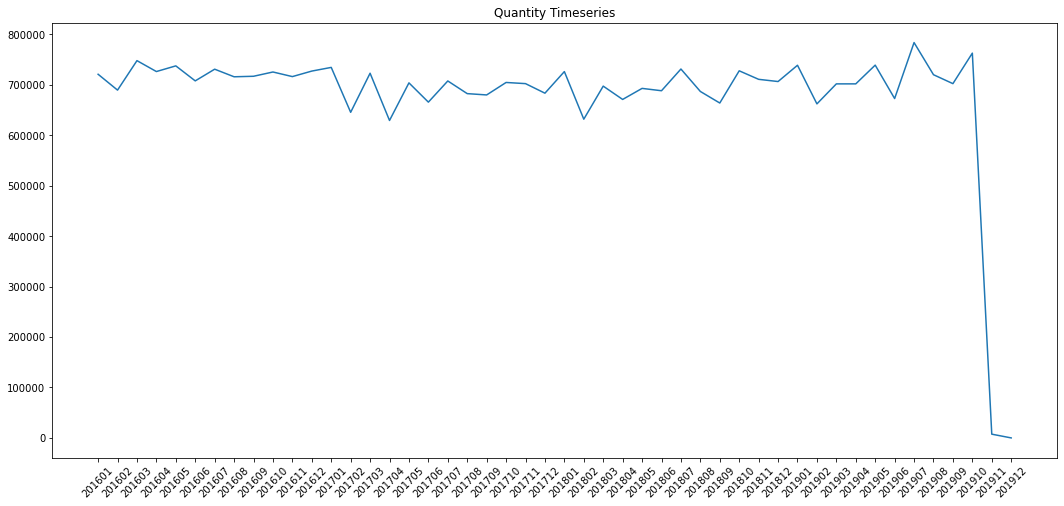

In [49]:
family_analysis('1')

monthly timeseries generated
13


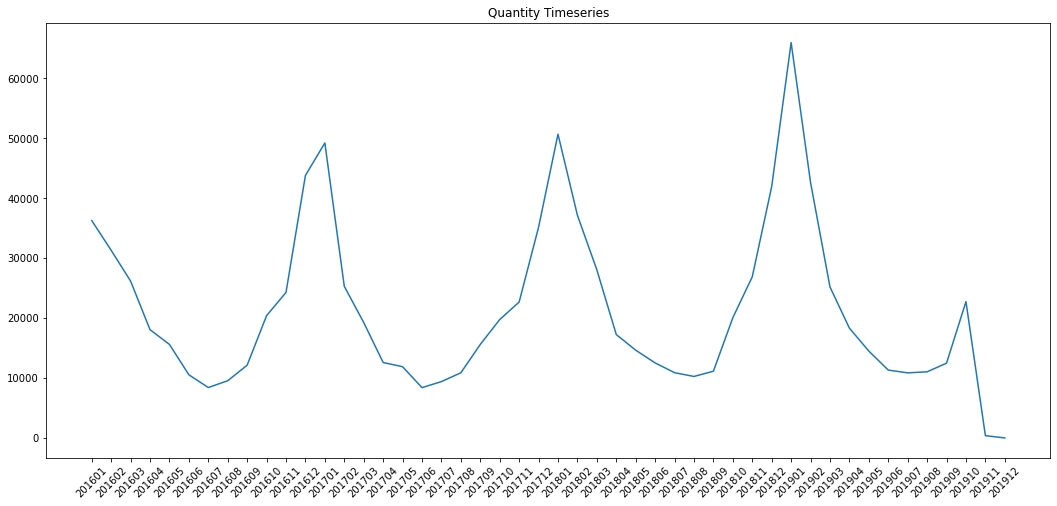

In [53]:
family_analysis('13')

### **Profiling of groups of Family Products**
Based on the seasonality analysis


\
- **Family Product No-seasonal**
  - 1
  - 10
  - 11
  - 12
  - 2
  - 6
  - 7
  - 9
  - 18
  - 21
  - 4
  - 5

- **Family Product seasonal** (increasing quantity in winter)
  - 13
  - 14
  - 15
  - 16
  - 20
  - 17

- **Increasing Pattern, No-seasonal**
  - 3
  - 8

- **Outlier**
  - 19 (starting only from November 2017)
